In [2]:
%run 'utils/imports.ipynb'

ERROR:root:File `'utils/imports.ipynb.py'` not found.


## Sieci bayesowskie

Sieć bayesowska składa się z następujących elementów [[1](https://www.springer.com/gp/book/9780387682815)]:
* zbioru zmiennych oraz zbioru połączeń między zmiennymi,
* zbioru stanów zmiennych, które są wzajemnie wykluczające się ze stanami innych zmiennych,
* skierowanego grafu acyklicznego (ang. _DAG - Directed Acyclic Graph_),
* zbioru tabel prawdopodobieństw warunkowych, w których znana jest wartość P(A | B1, B2, .. Bn), gdzie A to stan danej zmiennej, a B1 - Bn to stany rodziców zmiennej.

Innymi słowy, sieć bayesowska to probabilistyczny model graficzny przedstawiający zbiór zmiennych i ich warunkowe zależności w postaci skierowanego grafu acyklicznego.

Przykładowa sieć:

<img src="img/simple_bayes_net.png" alt="Naive net" style="height: 350px;"/>

Na podstawie powyższej sieci można stwierdzić, że deszcz wpływa na to, czy zraszacz wody jest włączony lub wyłączony, natomiast zarówno zraszacz, jak i deszcz wpływają na to, czy trawa jest mokra, czy nie [[2](https://en.wikipedia.org/wiki/Bayesian_network)].

Dysponując tabelami prawdopodobieństw warunkowych (ang. _CPT - Conditional Probability Tables_) możliwe jest wyznaczenie dowolnego prawdopodobieństwa zestawu stanów zmiennych, na przykład prawdopodobieństwo włączonego zraszacza pod warunkiem, że deszcz padał, a trawa jest mokra. W takim wypadku zmienna `zraszacz` jest **atrybutem-klasą** - elementem, który jest klasyfikowany do któregoś ze swoich stanów. Do tego celu wykorzystuje się regułę łańcuchową (ang. _chain rule_):

$$P(U)=P(A_{n} | A_{1}, ... , A_{n-1}) P(A_{n-1} | A_{1}, ... , A_{n-2}) ... P(A_{2} | A_{1})P(A_{1})   $$

W praktyce reguła łańcuchowa sprowadza się do wymnożenia odpowiednich wartości z tabel CPT. 

------

###### Konstrukcja sieci
W niniejszym skrypcie został przedstawiony proces konstrukcji sieci bayesowskich na podstawie przekazanych zgromadzonych danych. 

Dane niezbędne do konstrukcji sieci powinny zostać dostarczone w formacie [ARFF](https://www.cs.waikato.ac.nz/ml/weka/arff.html).
W pierwszym kroku należy wskazać ścieżkę do pliku ARFF oraz podać indeks atrybutu-klasy w tablicy atrybutów. 

W tablicy `arff_paths` przygotowano kilka ścieżek do plików ARFF oraz odpowiadające im indeksy atrybutów do klasyfikacji:

* `credit.arff` - pomaga sprawdzić zdolność kredytową na podstawie podanych danych (klasyfikacja `good` lub `bad`), 
* `tumor.arff` - pomaga klasyfikować pod kątem rodzaju nowotworu, jaki może pojawić się u pacjenta o podanych cechach, 
* `patient.arff` - zawiera dane pomagające zdecydować, czy pacjent powinien zostać wysłany do domu, czy też pozostać na oddziale (`I` - wysłanie do działu intensywnej terapii, `S` - przygotowanie pacjenta do wypisania ze szpitala, `A` - wysłanie pacjenta do skrzydła poradni ogólnej),
* `car.arff` - na podstawie informacji o samochodzie pozwala sklasyfikować samochód jako nadający lub nienadający się do zakupu,
* `zoo.ardd` - wytrenowana na danych z tego pliku sieć klasyfikuje stworzenie jako konkretny gatunek na podstawie informacji dotyczących m.in. zewnętrznego wyglądu (pióra, sierść, liczba odnóży) i środowiska, w którym żyje

In [3]:
arff_paths = [{'path': 'data/car.arff', 'class_index': 6},     #0
             {'path': 'data/credit.arff', 'class_index': 20},  #1
             {'path': 'data/patient.arff', 'class_index': 8},  #2
             {'path': 'data/tumor.arff', 'class_index': 17},   #3
             {'path': 'data/weather.arff', 'class_index': 4},  #4
             {'path': 'data/zoo.arff', 'class_index': 0}]      #5

W celu wybrania konkretnej ścieżki pliku, należy odpowiednio zmodyfikować zmienną `arff_file_index`:

In [4]:
arff_file_index = 4

Wybrany plik ARFF zostanie załadowany do trzech zmiennych:
* `attributes` - atrybuty (zmienne) i ich stany,
* `training_data` - dane trenujące,
* `testing_data` - dane testujące

Zbiór danych testowych jest dzielony na zbiór trenujący i testujący. Poziom podziału definiuje się procentowo za pomocą zmiennej `percentage_split`. Domyślnie jest to 50%. 

Po wykonaniu poniższego kodu, użytkownikowi zostaną zaprezentowane szczegóły wybranego atrybutu-klasy.

In [5]:
attributes, training_data, testing_data = ARFFLoader(arff_path=arff_paths[arff_file_index]['path'], debug=True)\
                                          .load_attributes_and_samples(class_attribute_index=arff_paths[arff_file_index]['class_index'], 
                                                                       percentage_split=50)

Class argument of weather.symbolic: 
{'name': 'play', 'states': ['yes', 'no']}


------
##### Założenia

Prezentowane w niniejszym skrypcie sieci opierają się na:
* kompletnych, znanych danych testowych,
* nieznanej strukturze sieci,
* nieznanych prawdopodobieństwach brzegowych atrybutów.

##### Algorytmy

Aby móc z powodzeniem korzystać z sieci bayesowskich, należy wyznaczyć ostatnie dwa punkty z powyższej listy.
Zaimplementowano trzy algorytmy uczenia sieci:
* Algorytm K2 ([więcej szczegółów](algorithms/k2algorithm.ipynb))
* Algorytm TAN ([więcej szczegółów](algorithms/tabualgorithm.ipynb))
* Algorytm TABU ([więcej szczegółów](algorithms/tanalgorithm.ipynb))

W dalszej sekcji zaprezentowano wyniki działania każdego z powyższych algorytmów.

##### Miary oceny sieci

Sieć bayesowska może zostać oceniona pod kątem zgodności z dostarczonymi danymi testowymi. Zaimplementowano nastepujące miary oceny sieci ([więcej szczegółów](utils/metrics.ipynb)):
* Miara MDL - Minimum Description Length,
* Miara AIC,
* Entropia

_Każdy z algorytmów oraz miary oceny sieci zostały szczegółowo opisane w skryptach, do których prowadzą linki `więcej szczegółów`._

------
## Algorytm K2

W tym algorytmie sprawdzane są wszystkie możliwe połączenia pomiędzy atrybutem, a atrybutami występującymi wcześniej w kolejności w liście atrybutów z pliku ARFF. Wybierane jest połączenie o największej wartości miary oceny sieci. 

###### Oznaczenia
1. `k2_score_method` może przyjąć wartości `mdl`, `aic` oraz `entropy`,
2. `k2_number_of_parents` określa maksymalną liczbę rodziców węzła.

_Więcej szczegółów na temat algorytmu K2 [tutaj]()._

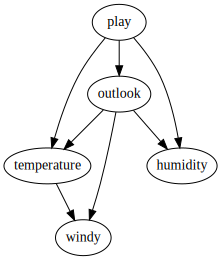

In [6]:
k2_score_method = 'mdl' #'aic' #'entropy'
k2_number_of_parents = 2
k2_network = K2Algorithm(attributes=attributes, 
                         sample_data=training_data, 
                         score_method=k2_score_method, 
                         number_of_parents=k2_number_of_parents).find_optimal_net()

Graph(k2_network).draw_graph()

-----
## Algorytm TAN

Algorytm TAN (ang. _Tree Augumented Naive Bayes_) polega na wytworzeniu połączeń pomiędzy węzłami w drzewie zbudowanym według zasad konstrukcji naiwnej sieci bayesowskiej. 

###### Naiwna sieć bayesowska
Naiwna sieć bayesowska oparta jest na założeniu o wzajemnej niezależności predyktorów [[3](https://pl.wikipedia.org/wiki/Naiwny_klasyfikator_bayesowski)]. Zakłada się więc, że poszczególne przesłanki danego faktu nie mają ze sobą nic wspólnego, co rzadko ma miejsce w rzeczywistym świece. Przykład:

<img src="img/naive_net.png" alt="Naive net" style="height: 120px;"/>

W powyższym przypadku sieć prezentuje brak zależności pomiędzy pogodą a temperaturą, co oczywiście może być błędnym założeniem.

Algorytm TAN rozszerza naiwną sieć bayesowską o połączenia pomiędzy przesłankami. W kolejnych krokach algorytmu każde potencjalne połączenie otrzynuje wagę - stopień wzajemnego powiązania poszczególnych przesłanek [[4](https://en.wikipedia.org/wiki/Conditional_mutual_information)]. Następnie, biorąc pod uwagę otrzymane wagi, tworzone jest minimalne drzewo rozpinające [[5](https://pl.wikipedia.org/wiki/Minimalne_drzewo_rozpinające)]. Wynikowy graf jest siecią bayesowską. 

_Więcej szczegółów na temat algorytmu TAN [tutaj]()._

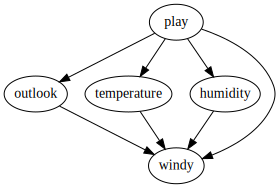

In [7]:
tan_network = TANAlgorithm(attributes=attributes, 
                           sample_data=training_data).find_optimal_net()

Graph(tan_network).draw_graph()

-----
## Algorytm TABU

Algorytm TABU sprawdza zachłannie wszystkie możliwe połączenia lub usunięcia połączeń w grafie i wybiera taką operację, która zapewni wzrost wartości zmiany oceny sieci. Takie działanie może doprowadzić do zatrzymania się w lokalnym maksimum oceny sieci. Z tego powodu ostatnie `tl` operacji przechowywanych jest na tzw. **liście TABU**. Algorytm ignoruje wszystkie operacje obecne na tablicy TABU. 

###### Oznaczenia
1. `tabu_score_method` może przyjąć wartości `mdl`, `aic` oraz `entropy`,
2. `tabu_max_number_of_parents` określa maksymalną liczbę rodziców węzła,
3. `tabu_number_of_iterations` określa liczbę iteracji algorytmu,
4. `tabu_list_length` określa długość listy TABU.

**Uwaga!** _Algorytm przeszukuje cały graf w poszukiwaniu najlepszego usunięcia lub stworzenia połączenia między węzłami. Z tego powodu podanie dużej liczby iteracji i/lub dużej maksymalnej liczby rodziców pojedynczego węzła, szczególnie w przypadku danych z wieloma atrybutami, może znacznie wydłużyć pracę algorytmu._

_Więcej szczegółów na temat algorytmu TABU [tutaj]()._

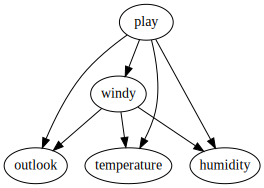

In [8]:
tabu_score_method = 'entropy' #'mdl' #'entropy'
tabu_max_number_of_parents = 2
tabu_number_of_iterations = 15
tabu_list_length = 2

tabu_network = TabuSearch(attributes=attributes,
                          sample_data=training_data,
                          score_method=tabu_score_method, 
                          number_of_parents=tabu_max_number_of_parents, 
                          number_of_iterations=tabu_number_of_iterations, 
                          tabu_length=tabu_list_length).find_optimal_net()

Graph(tabu_network).draw_graph()

-----
## K-krotna walidacja krzyżowa

K-krotna walidacja krzyżowa polega na podziale danych testowych na podzbiory, z których na zmianę jeden z podzbiorów uznawany jest za zbiór uczący, a pozostałe za zbiór walidacyjny [[5](https://pl.wikipedia.org/wiki/Sprawdzian_krzyżowy)]. Analiza jest więc wykonywana `K` razy. W przypadku metody `perform_k_fold_cross_validation` klasy `KFoldCrossValidation` za liczbę analiz odpowiada argument `n_splits`. Wszystkie przedstawione algorytmy są algorytmami uczenia się z nadzorem, dlatego analiza polega na sprawdzeniu zgodności klasyfikacji z danymi z dostarczonego zbioru.

Poniższy kod wykona K-krotną walidację krzyżową, po czym przedstawi wyniki w postaci wykresu słupkowego. Wartości na wykresie są wartościami średnimi.

Podczas wykonywania walidacji wyświetlany jest pasek postępu. Dla każdego z algorytmów w tablicy `classifiers` wyświetlony zostanie oddzielny pasek postępu.

_Z powodu wyszukiwania nowej struktury sieci każdorazowo przy każdej zmianie zbioru uczącego i walidacyjnego, wykonywanie walidacji krzyżowej może zająć do kilku minut_

<img src="img/cross_validation.png" alt="CrossValidation" style="height: 320px;"/>

[[źródło](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)]

FILE data/credit.arff
K2/MDL/2p:


TAN:


TABU/1p/2i/3tl:


Means [0.7329999999999999, 0.8240000000000001, 0.698]


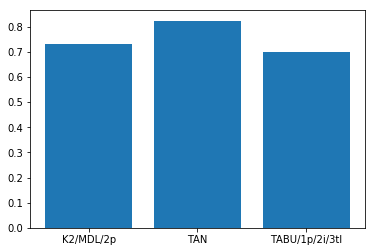

In [9]:
arff_index = 1
results = []
n_splits = 4
classifiers = [{"clf": K2Algorithm(score_method='mdl', number_of_parents=2), "name": "K2/MDL/2p"},
              {"clf": TANAlgorithm(), "name": "TAN"},
              {"clf": TabuSearch(score_method='mdl', number_of_parents=1, number_of_iterations=2, tabu_length=3), "name": "TABU/1p/2i/3tl"}]

print("FILE", arff_paths[arff_index]['path'])

for classifier in classifiers:
    print(classifier["name"] + ":")
    
    mean = KFoldCrossValidation(arff_paths[arff_index]['path'], arff_paths[arff_index]['class_index'])\
    .perform_k_fold_cross_validation(n_splits, classifier["clf"]).mean()
    
    results.append({"desc": classifier["name"], "result": mean})

    
mean_values = [r['result'] for r in results]
descriptions = [r['desc'] for r in results]

print("Means", mean_values)

plt.bar(descriptions, mean_values)
plt.show()

-----
## Klasyfikacja przy dowolnych podanych warunkach
Aby skorzystać ze skonstruowanej sieci, należy wyznaczyć prawdopodobieństwo klasyfikacji w poszczególne stany atrybutu-klasy. Służy do tego klasa `From`, która w stylu wzorca budowniczego uzupełnia poszczególne warunki. Przykład:

```python
From(bayesian_network, sample_data)
    .given('outlook', 'suuny')
    .given('temperature', 'hot')
    .given('humidity', 'high')
    .given('windy', 'false')
    .classify('play')
```

W pierwszej kolejności należy wybrać jedną z wcześniej utworzonych sieci. Do wyboru są zmienne `k2_network`, `tan_network` oraz `tabu_network`:

In [10]:
network = k2_network #tan_network #tabu_network

Poniżej zamieszczono przykładowe wywołanie dla każdego pliku ARFF z tablicy `arff_paths`. 

Aby zmienić plik ARFF, należy zmodyfikować zmienną `arff_file_index` i uruchomić ponownie wszystkie komórki ninejszego skryptu.

 #### 0 - car.arff

In [11]:
if arff_file_index == 0:
    pp.pprint(From(network, testing_data)\
        .given('buying', 'low')\
        .given('maint', 'low')\
        .given('doors', '5more')\
        .given('persons', '4')\
        .given('lug_boot', 'small')\
        .given('safety', 'med')\
        .classify('class'))

 #### 1 - credit.arff

In [12]:
if arff_file_index == 1:
    pp.pprint(From(network, testing_data)\
        .given('checking_status', '>=200')\
        .given('duration', "'\'")\
        .given('credit_history', 'all paid')\
        .given('purpose', 'new car')\
        .given('credit_amount', "'\'(-inf-3913.5]\''")\
        .given('savings_status', '<100')\
        .given('employment', 'unemployed')\
        .given('installment_commitment', "'\'All\''")\
        .given('personal_status', 'male single')\
        .given('other_parties', 'none')\
        .given('residence_since', "'\'All\'")\
        .given('property_magnitude', 'car')\
        .given('age', "'\'All\''")\
        .given('other_payment_plans', 'bank')\
        .given('housing', 'own')\
        .given('existing_credits', "'\'All\''")\
        .given('job', 'skilled')\
        .given('num_dependents', "'\'All\''")\
        .given('own_telephone', 'yes')\
        .given('foreign_worker', 'no')\
        .classify('class'))

 #### 2 - patient.arff

In [13]:
if arff_file_index == 2:
    pp.pprint(From(network, testing_data)\
        .given('L-CORE', 'high')\
        .given('L-SURF', 'low')\
        .given('L-O2', 'excellent')\
        .given('L-BP', 'mid')\
        .given('SURF-STBL', 'unstable')\
        .given('CORE-STBL', 'mod-stable')\
        .given('BP-STBL', 'stable')\
        .given('COMFORT', '07')\
        .classify('decision'))

 #### 3 - tumor.arff

In [14]:
if arff_file_index == 3:
    pp.pprin(From(network, testing_data)\
        .given('age', '30-59')\
        .given('sex', 'female')\
        .given('histologic-type', 'adeno')\
        .given('degree-of-diffe', 'fairly')\
        .given('bone', 'no')\
        .given('bone-marrow', 'yes')\
        .given('lung', 'no')\
        .given('pleura', 'yes')\
        .given('peritoneum', 'no')\
        .given('liver', 'no')\
        .given('brain', 'yes')\
        .given('skin', 'no')\
        .given('neck', 'no')\
        .given('supraclavicular', 'yes')\
        .given('axillar', 'yes')\
        .given('mediastinum', 'yes')\
        .given('abdominal', 'no')\
        .classify('class'))

 #### 4 - weather.arff

In [15]:
if arff_file_index == 4:
    pp.pprint(From(network, testing_data)\
        .given('outlook', 'overcast')\
        .given('temperature', 'mild')\
        .given('humidity', 'normal')\
        .given('windy', 'FALSE')\
        .classify('play'))

[{'state': 'yes', 'value': 92.5925925925926},
 {'state': 'no', 'value': 7.4074074074074066}]


 #### 5 - zoo.arff

In [16]:
if arff_file_index == 5:
    pp.pprint(From(network, testing_data)\
        .given('type', 'mammal')\
        .given('hair', 'true')\
        .given('feathers', 'false')\
        .given('eggs', 'false')\
        .given('milk', 'true')\
        .given('airborne', 'false')\
        .given('aquatic', 'false')\
        .given('predator', 'true')\
        .given('toothed', 'false')\
        .given('backbone', 'true')\
        .given('breathes', 'true')\
        .given('venomous', 'false')\
        .given('fins', 'false')\
        .given('legs', '4')\
        .given('tail', 'true')\
        .given('domestic', 'true')\
        .given('catsize', 'true')\
        .classify('animal'))